# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [1]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [2]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix

In [4]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [5]:
# define a function to load json file to a dataframe

import pandas as pd
import json

def load_ingredient_data(json_path):
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    df = pd.DataFrame(data)
    return df


##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [6]:
# read the json file by giving the file path and create a dataframe
ingredient_data_df = load_ingredient_data("ingredient_and_quantity.json")

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [7]:
# display first five rows of the dataframe - df
ingredient_data_df.head()


,input,pos
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4,1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient unit ingredient ingredient unit ingredient


In [8]:
# print the dimensions of dataframe - df
ingredient_data_df.shape


(285, 2)

In [9]:
# print the information of the dataframe
ingredient_data_df.info

<bound method DataFrame.info of                                                                                                                                                                                                                                                                                               input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                   6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli 

In [30]:
ingredient_data_df.describe()

,input,pos
count,285,285
unique,285,284
top,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
freq,1,2


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [31]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
# Tokenize POS

ingredient_data_df['input_tokens'] = ingredient_data_df['input'].apply(lambda x: x.split())
ingredient_data_df['pos_tokens'] = ingredient_data_df['pos'].apply(lambda x: x.split())

In [32]:
# display first five rows of the dataframe - df
ingredient_data_df.head()


,input,pos,input_tokens,pos_tokens
0,6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil,quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,"[6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]","[quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
1,2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida,quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient,"[2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]","[quantity, unit, ingredient, ingredient, quantity, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient]"
2,1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice,quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient,"[1-1/2, cups, Rice, Vermicelli, Noodles, Thin, 1, Onion, sliced, 1/2, cup, Carrots, Gajjar, chopped, 1/3, Green, peas, Matar, 2, Chillies, 1/4, teaspoon, Asafoetida, hing, Mustard, seeds, White, Urad, Dal, Split, Ghee, sprig, Curry, leaves, Salt, Lemon, juice]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient]"
3,500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and,quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient qua

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [33]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
ingredient_data_df['input_length'] = ingredient_data_df['input_tokens'].apply(len)
ingredient_data_df['pos_length'] = ingredient_data_df['pos_tokens'].apply(len)


In [34]:
# check for the equality of input_length and pos_length in the dataframe
mismatched_df = ingredient_data_df[ingredient_data_df['input_length'] != ingredient_data_df['pos_length']]


In [35]:
print("Total rows:", len(ingredient_data_df))
print("Rows with mismatched token lengths:", len(mismatched_df))

Total rows: 285
Rows with mismatched token lengths: 5


In [36]:
mismatched_df[['input', 'pos', 'input_length', 'pos_length']].head()

,input,pos,input_length,pos_length
17,2 cups curd 1 cup gourd cucumber green cor coriander 1/2 teaspoon cumin powder salt,quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient,15,14
27,1 Baguette sliced 1 1/2 tablespoon Butter 1/2 Garlic minced cup Spinach Leaves Palak Red Bell pepper Capsicum Tomato finely chopped Onion Black powder Italian seasoning teaspoon Fresh cream Cheddar cheese grated Salt Roasted tomato pasta sauce,quantity ingredient ingredient quantity unit ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,37,36
79,1/2 cup Poha Flattened rice 2 tablespoons Rice flour 2 1/2 liter Milk 1 Nolen Gur or brown sugar Cardamom Elaichi Pods/Seeds 8-10 Mixed nuts almonds/cashews tablespoon Raisins pinch Saffron strands and a little more for garnish Salt,quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity unit ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient unit ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient,38,37
164,1/2 cup All Purpose Flour Maida Whole Wheat 1/4 Hung Curd Greek Yogurt 250 grams Chicken minced 1 Spinach Leaves Palak finely chopped Onion 4 cloves Garlic Tomatoes tablespoon Cumin powder Jeera Coriander Powder Dhania 1 1/2 teaspoon Paprika Black pepper 3 sprig Mint Pudina 10 Spring Bulb & Greens 100 Feta Cheese crumbled,quantity unit ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient,54,53
207,1 cup Cashew nuts Badam Almond 1 1/4 cups Sugar 1/2 Water teaspoon Cardamom Powder Ghee for greasing,quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient quantity ingredient unit ingredient ingredient ingredient unit ingredient,18,17


##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [37]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(recipe_df, pos_coloumn_name):
    # Explode to get one label per row
    exploded_labels = recipe_df.explode(pos_coloumn_name)

    # Get unique labels
    unique_pos_labels = exploded_labels[pos_coloumn_name].unique()
    return unique_pos_labels


In [38]:
print("Unique POS labels in the dataset:")
print(unique_labels(ingredient_data_df, 'pos_tokens'))

Unique POS labels in the dataset:
['quantity' 'ingredient' 'unit']


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>


In [39]:
mismatched_indexes = mismatched_df.index.tolist()

In [40]:
mismatched_indexes

[17, 27, 79, 164, 207]

##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [41]:
# drop the irrelevant recipe data
df_cleaned = ingredient_data_df.drop(index=mismatched_indexes).reset_index(drop=True)


##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [42]:
# update the input and pos length in input_length and pos_length
df_cleaned['input_length'] = df_cleaned['input_tokens'].apply(len)
df_cleaned['pos_length'] = df_cleaned['pos_tokens'].apply(len)

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [43]:
# validate the input length and pos length as input_length and pos_length

mismatched_cleaned_df = df_cleaned[df_cleaned['input_length'] != df_cleaned['pos_length']]



In [44]:
print("Total rows:", len(df_cleaned))
print("Rows with mismatched token lengths:", len(mismatched_cleaned_df))

Total rows: 280
Rows with mismatched token lengths: 0


## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [45]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(df_cleaned[['input_tokens', 'pos_tokens']],test_size=0.3,random_state=42)


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [46]:
# print the first five rows of train_df
train_df.head()

,input_tokens,pos_tokens
175,"[250, grams, Okra, Oil, 1, Onion, finely, chopped, Tomato, Grated, teaspoon, Ginger, 2, Garlic, Finely, 1/2, Cumin, seeds, 1/4, Teaspoon, asafoetida, cup, cottage, cheese, pinched, coriander, powder, mango, red, chilli, turmeric]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
55,"[200, grams, Paneer, Homemade, Cottage, Cheese, 2, Potato, Aloo, Bay, leaf, tej, patta, Dry, Red, Chilli, 1, tablespoon, Panch, Phoran, Masala, roasted, and, powdered, Tomato, big, sized, teaspoon, Turmeric, powder, Haldi, Cumin, seeds, Jeera, Ginger, grated, Salt, 1/2, Sugar, Sunflower, Oil]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient]"
109,"[500, grams, Cabbage, Patta, Gobi, Muttaikose, 1, teaspoon, Mustard, seeds, 1-1/2, White, Urad, Dal, Split, sprig, Curry, leaves, Green, Chilli, 1/4, cup, Fresh, coconut, Salt]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient]"
213,"[500, grams, Fresh, Figs, 1/4, cup, Lemon, juice, 1, teaspoon, zest, 2, Red, Chilli, flakes, 1/2, Honey, Brown, Sugar, (Demerara, Sugar)]","[quantity, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, quantity, unit, ingredient, quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient]"
38,"[2, cups, Water, 1, teaspoon, Tea, leaves, 1/4, Milk, 10, Saffron, strands]","[quantity, unit, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, quantity, ingredient, ingredient]"


In [47]:
# print the first five rows of the val_df
val_df.head()


,input_tokens,pos_tokens
33,"[1, cup, Ada, 2, liter, Milk, 3/4, Sugar, tablespoon, Ghee, 1/2, teaspoon, Cardamom, Powder, Elaichi]","[quantity, unit, ingredient, quantity, unit, ingredient, quantity, ingredient, unit, ingredient, quantity, unit, ingredient, ingredient, ingredient]"
108,"[1, Carrot, Gajjar, chopped, 7, Potatoes, Aloo, 2, cups, Cauliflower, gobi, cut, to, small, florets, Onion, tablespoon, Ginger, Garlic, Paste, Salt, teaspoons, Sunflower, Oil, 1/2, cup, Fresh, coconut, grated, teaspoon, Whole, Black, Peppercorns, Green, Chillies, Fennel, seeds, Saunf, Poppy, 6, Cashew, nuts, inch, Cinnamon, Stick, Dalchini, Star, anise, 3, Cloves, Laung, Cardamom, Elaichi, Pods/Seeds, Cumin, Jeera]","[quantity, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
240,"[1, tablespoon, Sunflower, Oil, 3, Potato, Aloo, Ginger, paste, Green, Chilli, chopped, 1-1/12, tablespoons, Sesame, seeds, Til, teaspoon, Red, powder, Cumin, Jeera, Coriander, Powder, Dhania, 1/2, Garam, masala, 2, Sweet, Chutney, Date, Tamarind, Leaves, few]","[quantity, unit, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"
259,"[1, cup, green, peas, gram, flour, 1/2, cheese, tsp, ginger, 2, chillies, turmeric, powder, cumin, teaspoon, salt, oil]","[quantity, unit, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, unit, ingredient, quantity, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient]"
154,"[2, cups, Brown, Rice, cooked, tablespoons, Garlic, chopped, 1, Green, Chilli, 1/2, cup, Carrots, (Gajjar), beans, (French, Beans), Bell, Pepper, (Capsicum), Onion, Cabbage, (Patta, Gobi/, Muttaikose), tablespoon, Roasted, tomato, pasta, sauce, -, or, store, bought, Red, teaspoon, Soy, Ginger, freshly, grated, Spring, Greens, Salt, Vinegar, Extra, Virgin, Olive, Oil, as, required]","[quantity, unit, ingredient, ingredient, ingredient, unit, ingredient, ingredient, quantity, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]"


###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [48]:
# extract the training and validation sets by taking input_tokens and pos_tokens
# Extract input_tokens and pos_tokens
X_train = train_df['input_tokens'].tolist()
y_train = train_df['pos_tokens'].tolist()
X_val = val_df['input_tokens'].tolist()
y_val = val_df['pos_tokens'].tolist()

In [49]:
# validate the shape of training and validation samples
print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of X_val:", len(X_val))
print("Length of y_val:", len(y_val))


Length of X_train: 196
Length of y_train: 196
Length of X_val: 84
Length of y_val: 84


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [50]:
# Display the number of unique labels present in y_train

unique_labels = set(label for sequence in y_train for label in sequence)
print("Number of unique labels in y_train:", len(unique_labels))
print("Unique labels:", sorted(unique_labels))


Number of unique labels in y_train: 3
Unique labels: ['ingredient', 'quantity', 'unit']


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [51]:
# flatten the list for nested_list (input_tokens, pos_tokens)

def flatten_list(nested_list, dataset_name='Training'):
    print(f"Flattening {dataset_name} dataset...")
    flat_list = []
    for sublist in nested_list:
        flat_list.extend(sublist)
    return flat_list

In [52]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [53]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens

def extract_and_validate_tokens(df, dataset_name='Training'):    
    # Flatten the tokens
    flat_inputs = flatten_list(df['input_tokens'].tolist(), dataset_name)
    flat_labels = flatten_list(df['pos_tokens'].tolist(), dataset_name)

    print(f" input_tokens = {len(flat_inputs)}, pos_tokens = {len(flat_labels)}")
    
    # Validate lengths
    if len(flat_inputs) != len(flat_labels):
        print(f"Length mismatch: input_tokens = {len(flat_inputs)}, pos_tokens = {len(flat_labels)}")
    else:
        print(f"Length match: {len(flat_inputs)} tokens")

    # Display first 10 tokens
    print("\nFirst 10 input tokens:", flat_inputs[:10])
    print("First 10 POS tags:    ", flat_labels[:10])
        
    return flat_inputs , flat_labels


In [54]:
# extract the tokens and its pos tags
tokens, pos_tags = extract_and_validate_tokens(train_df, dataset_name='Training')


Flattening Training dataset...
Flattening Training dataset...
 input_tokens = 7114, pos_tokens = 7114
Length match: 7114 tokens

First 10 input tokens: ['250', 'grams', 'Okra', 'Oil', '1', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated']
First 10 POS tags:     ['quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [55]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays

def categorize_tokens(tokens, pos_tags):
    print("\nCategorizing tokens...")

    # Check lengths
    if len(tokens) != len(pos_tags):
        print("tokens and pos_tags must be the same length.")
        return [], [], []

    # Allowed tags
    allowed = ['ingredient', 'unit', 'quantity']
    
    # If any tag is not allowed, return empty
    for tag in pos_tags:
        if tag not in allowed:
            print("Found invalid tag:", tag)
            return [], [], [] 

    # Create category lists
    ingredients = []
    units = []
    quantities = []

    # Loop and assign based on tag
    for token, tag in zip(tokens, pos_tags):
        if tag == 'ingredient':
            ingredients.append(token)
        elif tag == 'unit':
            units.append(token)
        elif tag == 'quantity':
            quantities.append(token)

    return ingredients, units, quantities


In [56]:
#  call the function to categorise the labels into respective list
ingredients, units, quantities = categorize_tokens(tokens, pos_tags)

print("Ingredients:", ingredients[:10])
print("Units:", units[:10])
print("Quantities:", quantities[:10])


Categorizing tokens...
Ingredients: ['Okra', 'Oil', 'Onion', 'finely', 'chopped', 'Tomato', 'Grated', 'Ginger', 'Garlic', 'Finely']
Units: ['grams', 'teaspoon', 'Teaspoon', 'cup', 'grams', 'tablespoon', 'teaspoon', 'grams', 'teaspoon', 'sprig']
Quantities: ['250', '1', '2', '1/2', '1/4', '200', '2', '1', '1/2', '500']


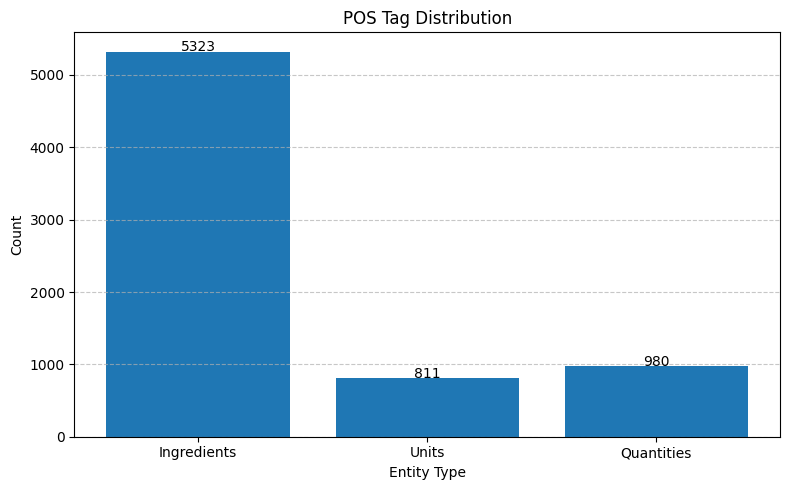

In [108]:
import matplotlib.pyplot as plt

# Sample lengths (assuming categorize_tokens returned real lists)
ingredient_count = len(ingredients)
unit_count = len(units)
quantity_count = len(quantities)

# Prepare data for plotting
labels = ['Ingredients', 'Units', 'Quantities']
counts = [ingredient_count, unit_count, quantity_count]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(labels, counts)
plt.title('POS Tag Distribution')
plt.ylabel('Count')
plt.xlabel('Entity Type')

# Annotate bars with counts
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 2, str(height), ha='center')

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [57]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
def get_top_frequent_items(item_list, title="Items"):
    print(f"\nTop 10 most frequent {title.lower()}:")
    top_items_10 = Counter(item_list).most_common(10)
    return top_items_10    

In [58]:
# get the top ingredients which are frequently seen in the recipe
top_items_ingredients = get_top_frequent_items(ingredients, title="Ingredients")
for item, count in top_items_ingredients:
        print(f"{item}: {count}")


Top 10 most frequent ingredients:
powder: 129
Salt: 102
seeds: 89
Green: 85
chopped: 84
Oil: 83
Red: 81
Chilli: 77
Coriander: 71
Sunflower: 65


In [59]:
# get the top units which are frequently seen in the recipe
top_items_units = get_top_frequent_items(units, title="Units")
for item, count in top_items_units:
        print(f"{item}: {count}")


Top 10 most frequent units:
teaspoon: 162
cup: 136
tablespoon: 99
grams: 63
tablespoons: 61
inch: 52
cups: 50
sprig: 41
cloves: 39
teaspoons: 39


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [60]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name


import matplotlib.pyplot as plt

def plot_top_items(item_list, label='Item', dataset_name='Dataset'):
    # Get top items using existing function
    top_items = get_top_frequent_items(item_list, title=label)
    
    # Unpack for plotting
    items, counts = zip(*top_items)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(items, counts)
    plt.title(f"Top 10 {label}s in {dataset_name} Dataset")
    plt.xlabel(label)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---




Top 10 most frequent ingredient:


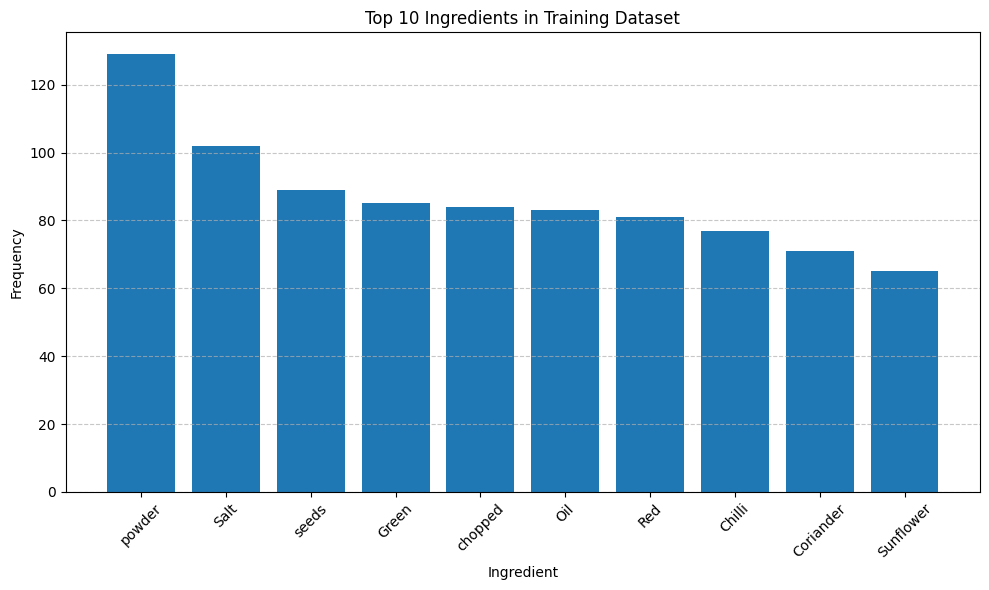

In [61]:
# plot the top frequent ingredients in training data
plot_top_items(ingredients, label='Ingredient', dataset_name='Training')



Top 10 most frequent unit:


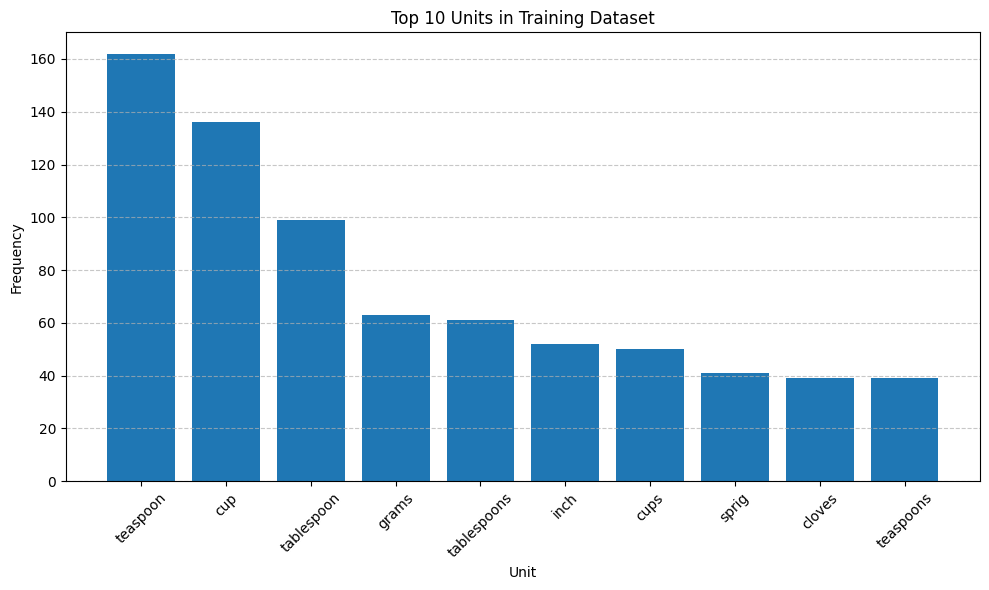

In [62]:
# plot the top frequent units in training data
plot_top_items(units, label='Unit', dataset_name='Training')

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [63]:
# initialise the dataset_name


In [64]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [65]:
# plot the top frequent ingredients in validation data


In [66]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [67]:
#unique_units = list(set(units))
#unique_quantities = list(set(quantities))

In [68]:
# define unit and quantity keywords along with quantity pattern

# will drop these inconsistenient unit
#[raw, cut, chopped, finely, thin, thick, small, long, whole, or, for]

unit_keywords = {
    'teaspoon', 'teaspoons', 'tsp',
    'tablespoon', 'tablespoons', 'tbsp',
    'cup', 'cups',
    'pinch', 'pinches',
    'gram', 'grams', 'gms',
    'ml', 'liter',
    'scoop', 'scoops',
    'clove', 'cloves',
    'drop', 'drops',
    'sprig', 'sprigs',
    'stalk', 'stalks',
    'inch', 'inches',
    'handful', 'fistful',
    'wedge', 'wedges'
}
quantity_keywords = {
    'half', 'quarter', 'third', 'few', 'little', 'some',
    'one', 'two', 'three', 'four', 'five', 'six',
    'seven', 'eight', 'nine', 'ten',
    'a', 'an', 'as', 'per', 'to', 'for', 'taste'
}
# Regex pattern to detect fractions, decimals, and whole numbers
quantity_pattern = re.compile(r'^(\d+([-/.]\d+)*|\d+\.\d+)$')

In [69]:
# load spaCy model

import spacy

# Load SpaCy English model
nlp = spacy.load("en_core_web_sm")


##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [70]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

    # Process the entire sentence with spaCy

    # --- Core Features ---

    # --- Improved Quantity & Unit Detection ---

    # --- Contextual Features ---


def word2features(sent, i):
    # Token and context
    token = sent[i]
    doc = nlp(token)[0]  # Process with spaCy

    features = {
        # --- Core Features ---
        'bias': 1.0,
        'token': token.lower(),
        'lemma': doc.lemma_.lower(),
        'pos_tag': doc.pos_,
        'tag': doc.tag_,
        'dep': doc.dep_,
        'shape': doc.shape_,
        'is_stop': doc.is_stop,
        'is_digit': token.isdigit(),
        'has_digit': any(c.isdigit() for c in token),
        'has_alpha': any(c.isalpha() for c in token),
        'hyphenated': '-' in token,
        'slash_present': '/' in token,
        'is_title': token.istitle(),
        'is_upper': token.isupper(),
        'is_punct': doc.is_punct,

        # --- Improved Quantity & Unit Detection ---
        'is_quantity': token.lower() in quantity_keywords or bool(quantity_pattern.match(token)),
        'is_unit': token.lower() in unit_keywords,
        'is_numeric': token.replace('.', '', 1).isdigit(),
        'is_fraction': '/' in token and all(part.isdigit() for part in token.split('/') if part),
        'is_decimal': '.' in token and token.replace('.', '', 1).isdigit()
    }

    # --- Contextual Features ---
    # Previous token
    if i > 0:
        prev_token = sent[i - 1].lower()
        features.update({
            'prev_token': prev_token,
            'prev_is_quantity': prev_token in quantity_keywords or bool(quantity_pattern.match(prev_token)),
            'prev_is_digit': prev_token.isdigit()
        })
    else:
        features['BOS'] = True  # Beginning of Sentence

    # Next token
    if i < len(sent) - 1:
        next_token = sent[i + 1].lower()
        features.update({
            'next_token': next_token,
            'next_is_unit': next_token in unit_keywords,
            'next_is_ingredient': next_token not in unit_keywords and next_token not in quantity_keywords
        })
    else:
        features['EOS'] = True  # End of Sentence

    return features



### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [71]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features

def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]


### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [72]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features
X_train_features = [sent2features(recipe) for recipe in X_train]
X_val_features = [sent2features(recipe) for recipe in X_val]


In [73]:
#for token_feats in X_train_features[0]:
    #print(token_feats)

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [74]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = y_train.copy()
y_val_labels = y_val.copy()


##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [75]:
# print the length of train features and labels
# Training set
print("Training Features:", len(X_train_features))
print("Training Labels:  ", len(y_train_labels))



Training Features: 196
Training Labels:   196


In [76]:
# print the length of validation features and labels

# Validation set
print("Validation Features:", len(X_val_features))
print("Validation Labels:  ", len(y_val_labels))

Validation Features: 84
Validation Labels:   84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [77]:
# Flatten labels in y_train
y_train_flat = [label for seq in y_train_labels for label in seq]


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [78]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts
from collections import Counter

label_counts = Counter(y_train_flat)
total_samples = sum(label_counts.values())


In [79]:
print("Label Counts:", label_counts)
print("Total Samples:", total_samples)

Label Counts: Counter({'ingredient': 5323, 'quantity': 980, 'unit': 811})
Total Samples: 7114


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [80]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts

weight_dict = {
    label: total_samples / count
    for label, count in label_counts.items()
}

In [81]:
print("weight_dict (Inverse Frequency):")
for label, weight in weight_dict.items():
    print(f"{label}: {weight:.2f}")

weight_dict (Inverse Frequency):
quantity: 7.26
unit: 8.77
ingredient: 1.34


In [82]:
# penalise ingredient label
if 'ingredient' in weight_dict:
    weight_dict['ingredient'] *= 2


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [83]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
    features = []
    labels = []
    for sent_tokens, label_seq in zip(X, y):
        sent_features = sent2features(sent_tokens)
        weights = [weight_dict.get(label, 1.0) for label in label_seq]
        features.append(sent_features)
        labels.append(label_seq)
    return features, labels

##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [84]:
# Apply manually computed class weights
X_train_weighted_features, y_train_weighted_labels = extract_features_with_class_weights(X_train, y_train, weight_dict)
X_val_weighted_features, y_val_weighted_labels = extract_features_with_class_weights(X_val, y_val, weight_dict)


In [85]:
print("Training samples:", len(X_train_weighted_features))
print("Training labels: ", len(y_train_weighted_labels))


print("\nValidation samples:", len(X_val_weighted_features))
print("Validation labels: ", len(y_val_weighted_labels))


Training samples: 196
Training labels:  196

Validation samples: 84
Validation labels:  84


## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [86]:
# initialise CRF model with the specified hyperparameters and use weight_dict
import sklearn_crfsuite
from sklearn_crfsuite import CRF

# Initialize the CRF model
crf_model = CRF(
    algorithm='lbfgs',
    c1=0.5,
    c2=1.0,
    max_iterations=100,
    all_possible_transitions=True
)

In [87]:
# train the CRF model with the weighted training data
crf_model.fit(
    X_train_weighted_features,
    y_train_weighted_labels
)


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=1.0,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [88]:
# evaluate on the training dataset
y_train_pred = crf_model.predict(X_train_weighted_features)


In [89]:
# specify the flat classification report by using training data for evaluation
print("Classification Report on Training Data:")
print(metrics.flat_classification_report(
    y_train_weighted_labels,      # true labels
    y_train_pred,                 # predicted labels
    digits=3                      # precision for floating points
))


Classification Report on Training Data:
              precision    recall  f1-score   support

  ingredient      0.993     0.996     0.994      5323
    quantity      0.996     0.986     0.991       980
        unit      0.976     0.970     0.973       811

    accuracy                          0.991      7114
   macro avg      0.988     0.984     0.986      7114
weighted avg      0.991     0.991     0.991      7114



In [90]:
# create a confusion matrix on training datset
from sklearn_crfsuite import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [91]:
y_true_flat = [label for seq in y_train_weighted_labels for label in seq]
y_pred_flat = [label for seq in y_train_pred for label in seq]

In [92]:
labels = sorted(list(set(y_true_flat + y_pred_flat)))

In [93]:
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

<Figure size 1000x800 with 0 Axes>

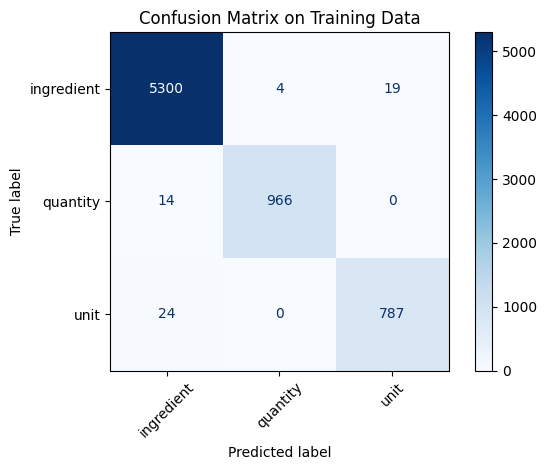

In [94]:
labels = sorted(list(set(y_true_flat + y_pred_flat)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix on Training Data")
plt.tight_layout()
plt.show()

### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [95]:
# dump the model using joblib as crf_model.pkl
joblib.dump(crf_model, 'crf_model.pkl')
print("CRF model saved as 'crf_model.pkl'")

CRF model saved as 'crf_model.pkl'


In [96]:
crf_model = joblib.load('crf_model.pkl')
print("CRF model loaded from 'crf_model.pkl'")

CRF model loaded from 'crf_model.pkl'


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [97]:
# predict the crf model on validation dataset
y_val_pred = crf_model.predict(X_val_weighted_features)


In [98]:
# specify flat classification report
print("Classification Report on Validation Data:")
print(metrics.flat_classification_report(
    y_pred=y_val_pred,
    y_true=y_val_weighted_labels,
    digits=3  # show scores with 3 decimal places
))


Classification Report on Validation Data:
              precision    recall  f1-score   support

  ingredient      0.984     0.996     0.990      2107
    quantity      0.988     0.985     0.987       411
        unit      0.979     0.911     0.944       358

    accuracy                          0.984      2876
   macro avg      0.983     0.964     0.973      2876
weighted avg      0.984     0.984     0.983      2876



In [99]:
# create a confusion matrix on validation dataset
y_val_true_flat = [label for seq in y_val_weighted_labels for label in seq]
y_val_pred_flat = [label for seq in y_val_pred for label in seq]


<Figure size 1000x800 with 0 Axes>

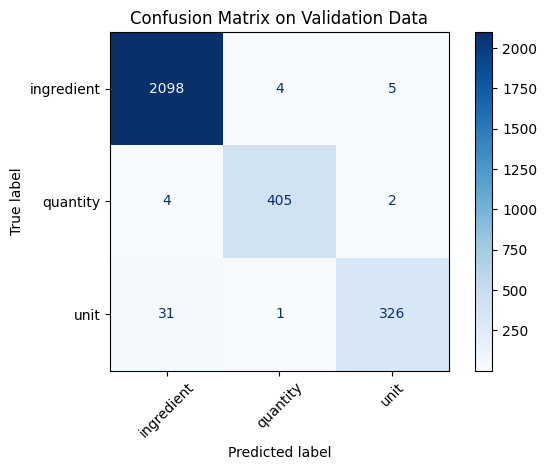

In [100]:
# Generate confusion matrix
cm = confusion_matrix(y_val_true_flat, y_val_pred_flat, labels=labels)

# Display the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(10, 8))
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix on Validation Data")
plt.tight_layout()
plt.show()

## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [101]:
# flatten Labels and Initialise Error Data
error_data = []

for true_label, pred_label in zip(y_val_true_flat, y_val_pred_flat):
    if true_label != pred_label:
        error_data.append((true_label, pred_label))


In [102]:
print("Sample misclassified labels:")
for i, (true, pred) in enumerate(error_data[:10]):
    print(f"{i+1}. True: {true}, Predicted: {pred}")

Sample misclassified labels:
1. True: ingredient, Predicted: quantity
2. True: ingredient, Predicted: unit
3. True: unit, Predicted: ingredient
4. True: quantity, Predicted: ingredient
5. True: ingredient, Predicted: quantity
6. True: quantity, Predicted: ingredient
7. True: quantity, Predicted: ingredient
8. True: quantity, Predicted: ingredient
9. True: unit, Predicted: ingredient
10. True: unit, Predicted: ingredient


##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [103]:
# iterate and collect Error Information

            # get previous and next tokens with handling for boundary cases

error_data = []

for sent_idx in range(len(X_val_weighted_features)):
    features = X_val_weighted_features[sent_idx]
    true_labels = y_val_weighted_labels[sent_idx]
    pred_labels = y_val_pred[sent_idx]

    for i, (true_label, pred_label) in enumerate(zip(true_labels, pred_labels)):
        if true_label != pred_label:
            # Get the current token
            token = features[i]['token'] if 'token' in features[i] else 'UNK'

            # Get previous and next tokens if available
            prev_token = features[i - 1]['token'] if i > 0 else 'BOS'
            next_token = features[i + 1]['token'] if i < len(features) - 1 else 'EOS'

            # Get class weight for the true label
            weight = weight_dict.get(true_label, 1.0)

            # Collect error details
            error_data.append({
                'sentence_index': sent_idx,
                'token_index': i,
                'token': token,
                'true_label': true_label,
                'predicted_label': pred_label,
                'prev_token': prev_token,
                'next_token': next_token,
                'class_weight': weight
            })



In [104]:
print("Sample Misclassifications with Context:")
for err in error_data[:5]:
    print(f"\nToken: {err['token']}")
    print(f"True Label: {err['true_label']} | Predicted Label: {err['predicted_label']}")
    print(f"Prev: {err['prev_token']} | Next: {err['next_token']}")
    print(f"Sentence Index: {err['sentence_index']} | Token Index: {err['token_index']}")
    print(f"Class Weight: {err['class_weight']}")

Sample Misclassifications with Context:

Token: few
True Label: ingredient | Predicted Label: quantity
Prev: leaves | Next: EOS
Sentence Index: 2 | Token Index: 34
Class Weight: 2.672928799549126

Token: cloves
True Label: ingredient | Predicted Label: unit
Prev: 3 | Next: garlic
Sentence Index: 5 | Token Index: 18
Class Weight: 2.672928799549126

Token: spoon
True Label: unit | Predicted Label: ingredient
Prev: big | Next: oil
Sentence Index: 5 | Token Index: 21
Class Weight: 8.771886559802713

Token: is
True Label: quantity | Predicted Label: ingredient
Prev: pur | Next: 2
Sentence Index: 13 | Token Index: 3
Class Weight: 7.259183673469388

Token: few
True Label: ingredient | Predicted Label: quantity
Prev: leaves | Next: EOS
Sentence Index: 15 | Token Index: 56
Class Weight: 2.672928799549126


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [105]:
# Create DataFrame and Print Overall Accuracy

total_tokens = len(y_val_true_flat)

error_df = pd.DataFrame(error_data)

# Total misclassified tokens
num_errors = len(error_df)

# Compute accuracy
accuracy = (total_tokens - num_errors) / total_tokens

print(f"\nValidation Accuracy: {accuracy:.3f} ({total_tokens - num_errors} correct out of {total_tokens})")



Validation Accuracy: 0.984 (2829 correct out of 2876)


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [106]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context

# Total label counts in validation data
label_totals = pd.Series(y_val_true_flat).value_counts().to_dict()

# Group errors by true label
error_summary = []

for label, group_df in error_df.groupby('true_label'):
    total = label_totals.get(label, 0)
    errors = len(group_df)
    accuracy = (total - errors) / total if total else 0
    weight = weight_dict.get(label, 1.0)

    error_summary.append({
        'Label': label,
        'Errors': errors,
        'Total Tokens': total,
        'Accuracy': round(accuracy, 3),
        'Class Weight': round(weight, 2)
    })

# Convert to DataFrame
error_analysis_df = pd.DataFrame(error_summary).sort_values(by='Errors', ascending=False)


In [107]:
print("Error Summary by Label:")
print(error_analysis_df)

Error Summary by Label:
        Label  Errors  Total Tokens  Accuracy  Class Weight
2        unit      32           358     0.911          8.77
0  ingredient       9          2107     0.996          2.67
1    quantity       6           411     0.985          7.26


### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

Your model achieves a high accuracy on the validation set — meaning it is learning meaningful token-label mappings.

Still, there are certain weak spots in distinguishing similar labels, especially ingredient, unit, and quantity.



## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.